Discussion of the GP marginal likelihood upper bound
--

*Mark van der Wilk, August 2017*  
*Small edits by James Hensman 2017*

See [gp_upper](https://github.com/markvdw/gp_upper) for code to tighten the upper bound through optimisation, and a more comprehensive discussion.

In [1]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

import numpy as np
import pandas as pd

import gpflow
from gpflow.test_util import notebook_niter

from FITCvsVFE import getTrainingTestData
from __future__ import print_function

In [2]:
X, Y, Xt, Yt = getTrainingTestData()

In [3]:
def plot_model(m, name=""):
    pX = np.linspace(-3, 9, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    plt.plot(X, Y, 'x')
    plt.plot(pX, pY)
    try:
        plt.plot(m.feature.Z.value, m.feature.Z.value * 0, 'o')
    except AttributeError:
        pass
    two_sigma = (2.0 * pYv ** 0.5)[:, 0]
    plt.fill_between(pX[:, 0], pY[:, 0] - two_sigma, pY[:, 0] + two_sigma, alpha=0.15)
    lml = m.compute_log_likelihood()
    plt.title("%s (lml = %f)" % (name, lml))
    return lml

## Full model

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 23.966658
  Number of iterations: 13
  Number of functions evaluations: 18


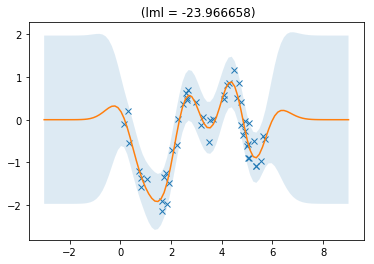

In [4]:
f = gpflow.models.GPR(X, Y, gpflow.kernels.RBF(1))
f.compile()
gpflow.train.ScipyOptimizer().minimize(f, maxiter=notebook_niter(1000))
full_lml = plot_model(f)

## Upper bounds for sparse variational models
As a first investigation, we compute the upper bound for models trained using the sparse variational GP approximation.

In [5]:
Ms = np.arange(4, notebook_niter(20, test_n=6), 1)
vfe_lml = []
vupper_lml = []
vfe_hyps = []
for M in Ms:
    Zinit = X[:M, :].copy()
    vfe = gpflow.models.SGPR(X, Y, gpflow.kernels.RBF(1), Zinit)
    vfe.compile()
    gpflow.train.ScipyOptimizer().minimize(vfe, disp=False, maxiter=notebook_niter(1000))
    
    vfe_lml.append(vfe.compute_log_likelihood())
    vupper_lml.append(vfe.compute_upper_bound())
    vfe_hyps.append({p.pathname:p.read_value() for p in vfe.trainable_parameters})
    print("%i" % M, end=" ")
vfe_hyps = pd.DataFrame(vfe_hyps)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 49.220787
  Number of iterations: 25
  Number of functions evaluations: 36
4 INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 40.211568
  Number of iterations: 50
  Number of functions evaluations: 81
5 INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 37.583478
  Number of iterations: 35
  Number of functions evaluations: 43
6 INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 30.092951
  Number of iterations: 32
  Number of functions evaluations: 49
7 INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 26.316172
  

Text(0.5,1,'LML bounds for models trained with SGPR')

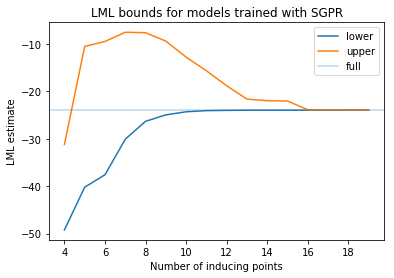

In [6]:
plt.plot(Ms, vfe_lml, label="lower")
plt.plot(Ms, vupper_lml, label="upper")
plt.axhline(full_lml, label="full", alpha=0.3)
plt.xlabel("Number of inducing points")
plt.ylabel("LML estimate")
plt.legend()
plt.title("LML bounds for models trained with SGPR")

We see that the lower bound increases as more inducing points are added. Note that the upper bound does _not_ monotonically decrease! This is because as we train the sparse model, we also get better estimates of the hyperparameters. The upper bound will be different for this different setting of the hyperparameters, and is sometimes looser. The upper bound also converges to the true lml slower than the lower bound.

## Upper bounds for fixed hyperparameters
Here, we train sparse models with the hyperparameters fixed to the optimal value found previously.

In [7]:
fMs = np.arange(3, notebook_niter(20, test_n=5), 1)
fvfe_lml = []  # Fixed vfe lml
fvupper_lml = []  # Fixed upper lml
for M in fMs:
    Zinit = vfe.feature.Z.read_value()[:M, :].copy()
    Zinit = np.vstack((Zinit, X[np.random.permutation(len(X))[:(M - len(Zinit))], :].copy()))
    init_params = {p.pathname:p.read_value() for p in vfe.parameters} # TODO: provide convenience function
    init_params['SGPR/feature/Z'] = Zinit
    vfe = gpflow.models.SGPR(X, Y, gpflow.kernels.RBF(1), Zinit)
    vfe.assign(init_params)
    vfe.kern.variance.set_trainable(False)
    vfe.kern.lengthscales.set_trainable(False)
    vfe.likelihood.set_trainable(False)
    vfe.compile()
    gpflow.train.ScipyOptimizer().minimize(vfe, disp=False)
    
    fvfe_lml.append(vfe.compute_log_likelihood())
    fvupper_lml.append(vfe.compute_upper_bound())
    print("%i" % M, end=" ")

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 180.921308
  Number of iterations: 13
  Number of functions evaluations: 22
3 INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 115.874193
  Number of iterations: 8
  Number of functions evaluations: 10
4 INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 78.818456
  Number of iterations: 11
  Number of functions evaluations: 14
5 INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68.877359
  Number of iterations: 12
  Number of functions evaluations: 14
6 INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 39.646882
 

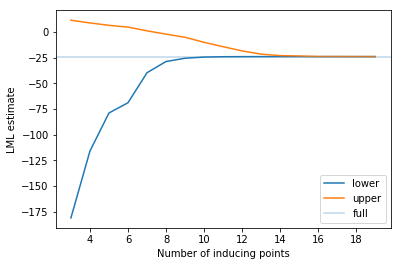

In [8]:
plt.plot(fMs, fvfe_lml, label="lower")
plt.plot(fMs, fvupper_lml, label="upper")
plt.axhline(full_lml, label="full", alpha=0.3)
plt.xlabel("Number of inducing points")
plt.ylabel("LML estimate")
plt.legend()

Now, as the hyperparameters are fixed, the bound _does_ monotonically decrease. We chose the optimal hyperparameters here, but the picture should be the same for any hyperparameter setting. This shows that we increasingly get a better estimate of the marginal likelihood as we add more inducing points.

## A tight estimate bound does not imply a converged model

In [9]:
vfe = gpflow.models.SGPR(X, Y, gpflow.kernels.RBF(1), X[None, 0, :].copy())
vfe.compile()
gpflow.train.ScipyOptimizer().minimize(vfe, maxiter=notebook_niter(1000))
print("Lower bound: %f" % vfe.compute_log_likelihood())
print("Upper bound: %f" % vfe.compute_upper_bound())

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 62.487090
  Number of iterations: 46
  Number of functions evaluations: 57
Lower bound: -62.487090
Upper bound: -62.484641


In this case we show that for the hyperparameter setting, the bound is very tight. However, this does _not_ imply that we have enough inducing points, but simply that we have correctly identified the marginal likelihood for this particular hyperparameter setting. In this specific case, where we used a single inducing point, the model collapses to not using the GP at all (lengthscale is really long to model only the mean). The rest of the variance is explained by noise. This GP can be perfectly approximated with a single inducing point.

In [10]:
vfe.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SGPR/kern/variance,Parameter,None,+ve,True,(),True,0.10775256810399733
SGPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1014.3847523740365
SGPR/feature/Z,Parameter,None,(none),True,"(1, 1)",True,[[2.6574094508]]
SGPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.6824319445027769


This can be diagnosed by showing that there are other hyperparameter settings with higher upper bounds. This indicates that there may be better hyperparameter settings, but we cannot identify them due to the lack of inducing points. An example of this can be seen in the previous section.